In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import linearmodels as lm
from tqdm.notebook import tqdm
import seaborn as sns


county_border_dma_dt = pd.read_parquet("./processed_files/county_border_dma_dt.parquet")

In [10]:
# Creating independent ads variables
ads_dt = pd.read_parquet("./processed_files/vivix_dt.parquet")
ads_dt["date"] = pd.to_datetime(ads_dt["date"])

## Creating aggregated by date, brand_id, dma_id
ads_dt = ads_dt.groupby(["brand_id","date","dma_id"],as_index=False).agg({"$":"sum","sec":"count"})
ads_dt = ads_dt.rename(columns={"$":"spend_ads", "sec":"num_ads"})

## Total US ads are set to have dma_id = 0
global_ads_dt = ads_dt[ads_dt["dma_id"]==0].copy().rename(columns={"spend_ads":"spend_ads_global", "num_ads":"num_ads_global"})
del global_ads_dt["dma_id"]
ads_dt = ads_dt[ads_dt["dma_id"]!=0].copy()
ads_dt = ads_dt.merge(global_ads_dt, how="left").fillna(0)



## Aggregate ads on brand,dma_id, date
ads_dt = ads_dt.groupby(["date","dma_id","brand_id"], as_index=False).agg({
                                                                    "spend_ads":"sum",
                                                                    "num_ads":"sum",
                                                                    "spend_ads_global":"sum", 
                                                                    "num_ads_global":"sum",
                                                                   })
print("Total ads rows after aggreegating by day", ads_dt.shape[0])

## Keep only dma_id that left in the bordering file
ads_dt = ads_dt.merge(county_border_dma_dt["dma_id"].drop_duplicates(), how="inner")
print("Total ads rows after keeping dma_id in border", ads_dt.shape[0])


Total ads rows after aggreegating by day 606687
Total ads rows after keeping dma_id in border 595349


In [11]:
# Load and preprocess the ads and transaction files
poi_dt = pd.read_parquet("./processed_files/poi_dt.parquet")

## Keep POIs in counties that kept after selecting the bordering ones
poi_dt = poi_dt.merge(county_border_dma_dt[["county_id"]].drop_duplicates(), how="inner")

# Creating Outcome data
tran_dt = pd.read_parquet("./processed_files/vertical_visit_spend.parquet")
tran_dt["date"] = pd.to_datetime(tran_dt["date"])

## Assume that 0 visits implies that the store was closed (should be fixed later)
tran_dt["num_visits"] = tran_dt["num_visits"].fillna(0)
tran_dt = tran_dt[tran_dt["open"]==1].copy()

## Keep only rows in kept counties and add border_id
tran_dt = tran_dt.merge(poi_dt[["placekey", "placekey_id", "brand_id", "county_id", "dma_id"]].drop_duplicates(), how="inner")
tran_dt = tran_dt.merge(county_border_dma_dt[["county_id" ,"border_id"]].drop_duplicates(), how="inner")



tran_dt["dma_id"] = tran_dt["dma_id"].fillna(-999).astype(int)
tran_dt["county_id"] = tran_dt["county_id"].fillna(-999).astype(int)


## Aggregate outcomes on brand, county, date level
tran_dt = tran_dt.groupby(["brand_id","date","county_id","dma_id","border_id"], as_index=False).agg({
                                                                                                "num_visits":"sum",
                                                                                                "spend":"sum",
                                                                                                "placekey_id":"nunique"
                                                                                               })
tran_dt = tran_dt.rename(columns={"placekey_id":"num_poi"})

## Last date would be Sunday
## First date is monday - easier to aggregate on week level
tran_dt = tran_dt[tran_dt["date"]<="2024-04-28"].copy()

In [12]:
# Define "time" - it could be day or week or month
# aggregate the data again in case time is not daily level
tran_dt["year"] = tran_dt["date"].dt.year
tran_dt["dayofyear"] = tran_dt["date"].dt.dayofyear
tran_dt["time"] = tran_dt["date"]
tran_dt["time"] = (tran_dt["dayofyear"]+(tran_dt["year"]==2023)*1)//7

ads_dt["year"] = ads_dt["date"].dt.year
ads_dt["dayofyear"] = ads_dt["date"].dt.dayofyear
ads_dt["time"] = ads_dt["date"]
ads_dt["time"] = (ads_dt["dayofyear"]+(ads_dt["year"]==2023)*1)//7



## Aggregate both ads and outcome on the new time variables (if it is daily it woulnt change anything)
tran_agg_dt = tran_dt.groupby(["brand_id", "time","county_id","dma_id","border_id"], as_index=False).agg({
                                                                    "num_visits":"sum",
                                                                    "spend":"sum",
                                                                    "num_poi":"sum"
                                                                   })

ads_agg_dt = ads_dt.groupby(["time","dma_id","brand_id"], as_index=False).agg({
                                                                    "spend_ads":"sum",
                                                                    "num_ads":"sum",
                                                                    "spend_ads_global":"sum", 
                                                                    "num_ads_global":"sum",
                                                                   })


In [13]:
# Merge outcome and ads datasets, aggregate on county level
# Should be accurate with aggregating the 
tran_ads_agg_dt = tran_agg_dt.merge(ads_agg_dt, how="left").fillna(0)

# Add logs and FEs (for county level, brand_id = "all" just to have less changes in next code)
all_var_l = ['spend_ads', 'num_ads','spend_ads_global', 'num_ads_global', 'num_visits', 'spend', 'num_poi']
tran_ads_agg_dt[[i+"_log" for i in all_var_l]] =  np.log(tran_ads_agg_dt[all_var_l]+1)

tran_ads_agg_dt["brand_border_time_fe"] = tran_ads_agg_dt["brand_id"].astype(str) + "_" +tran_ads_agg_dt["border_id"].astype(str) + "_" + tran_ads_agg_dt["time"].astype(str)
tran_ads_agg_dt["brand_county_fe"] = tran_ads_agg_dt["brand_id"].astype(str) + "_" +tran_ads_agg_dt["county_id"].astype(str)


In [14]:
# Requirement of linear models.
final_dt = tran_ads_agg_dt.set_index(["county_id","time"])
final_dt["interc"] = 1

In [15]:
y = "num_visits"
x = "num_ads"
x_control_l = ["interc"]

mod = lm.PanelOLS(final_dt[y], final_dt[x_control_l+[x]], other_effects=final_dt[["brand_border_time_fe","brand_county_fe"]], drop_absorbed=True)
res = mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:             num_visits   R-squared:                     6.503e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.2698
No. Observations:             1208872   R-squared (Within):               0.0020
Date:                Mon, Jul 22 2024   R-squared (Overall):              0.0015
Time:                        18:05:22   Log-likelihood                -9.432e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      47.723
Entities:                        1800   P-value                           0.0000
Avg Obs:                       671.60   Distribution:                F(1,733852)
Min Obs:                       40.000                                           
Max Obs:                       3295.0   F-statistic (robust):             47.723
                            

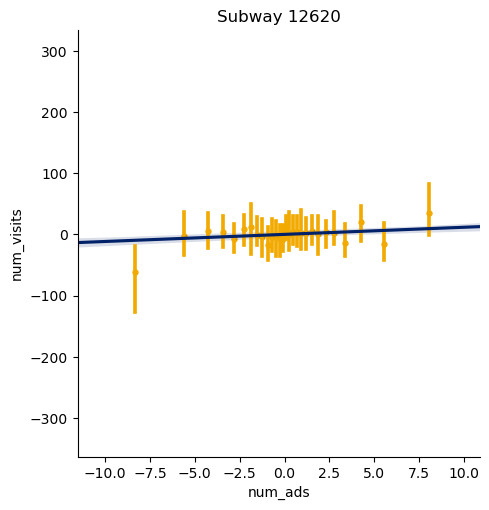

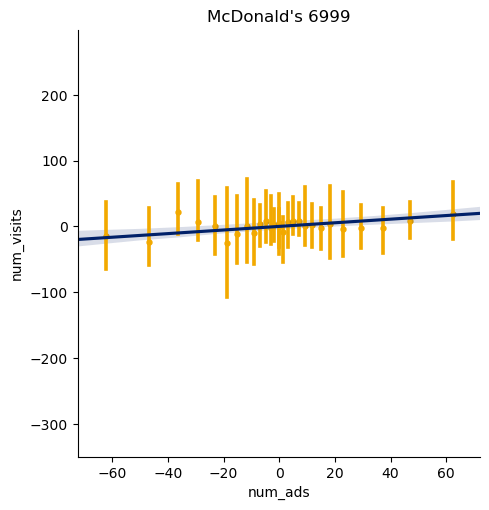

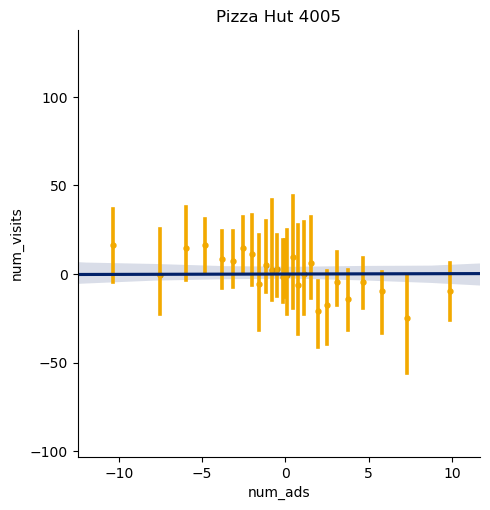

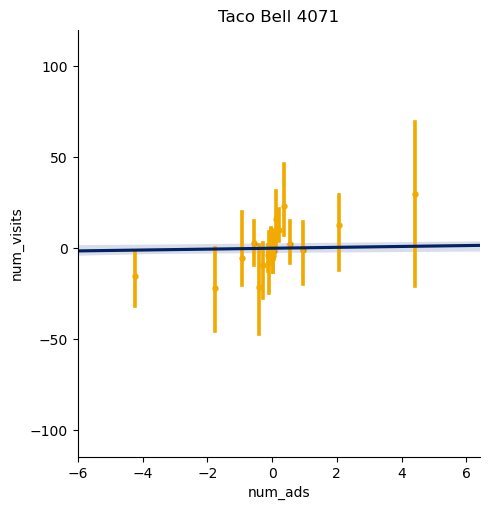

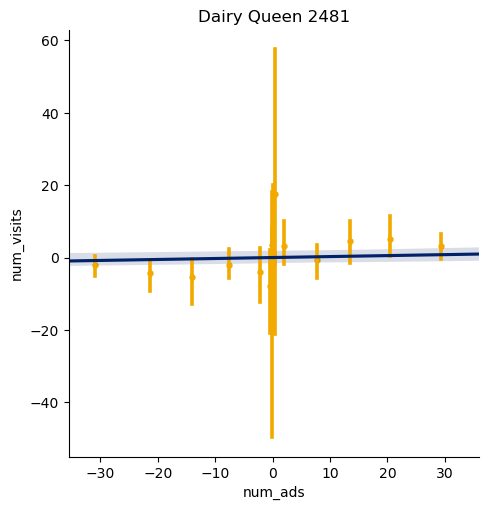

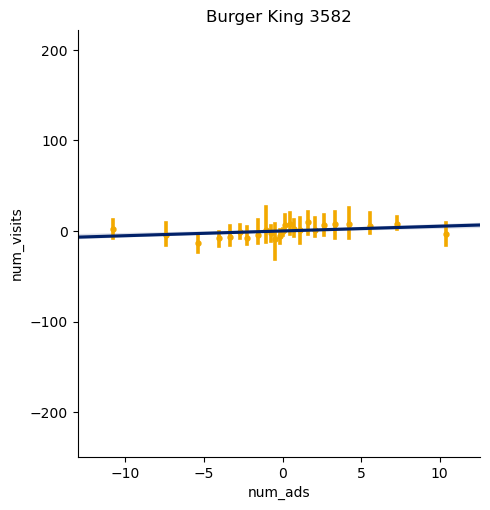

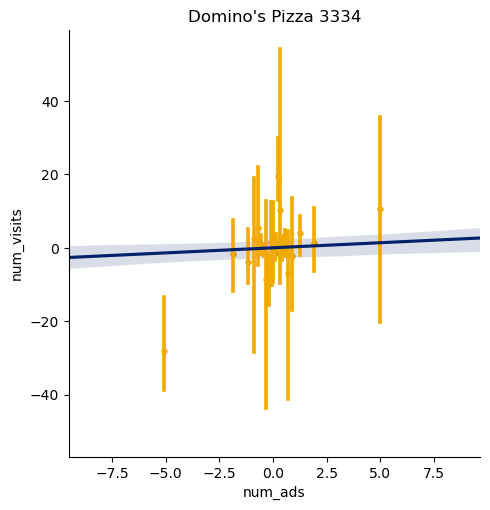

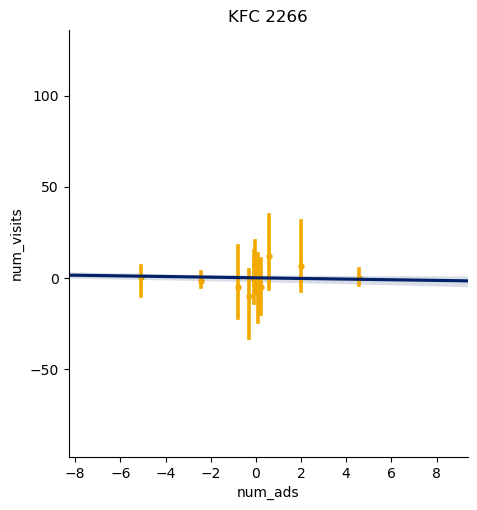

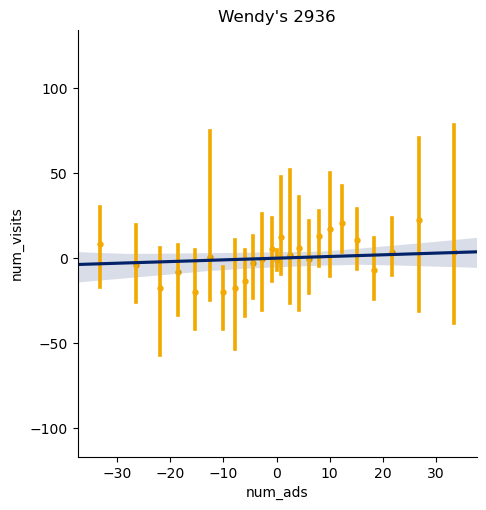

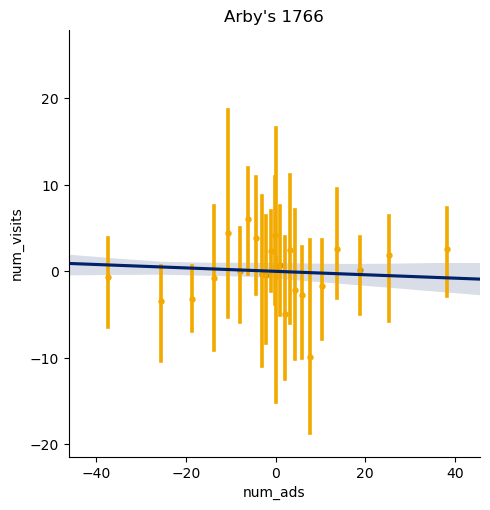

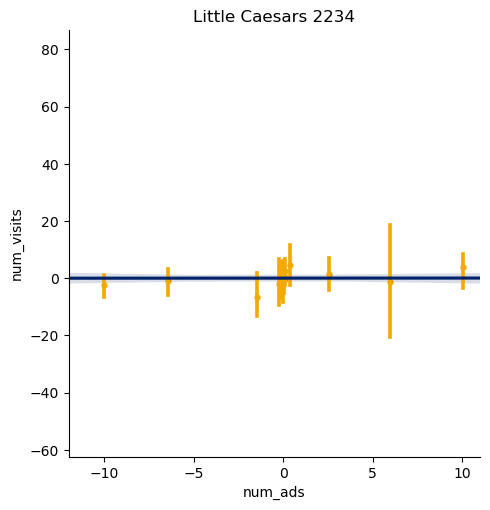

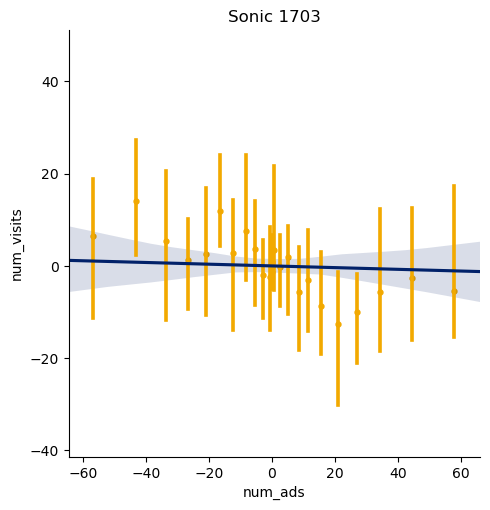

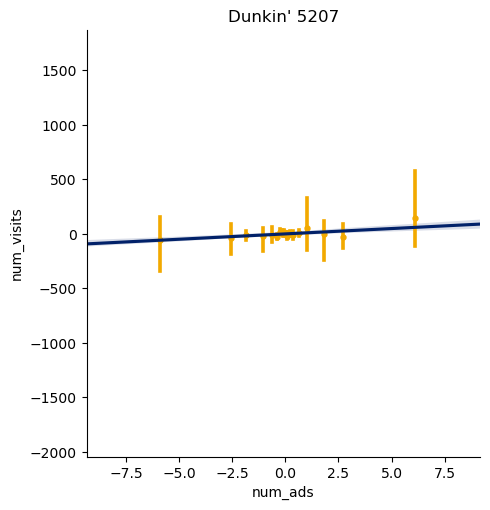

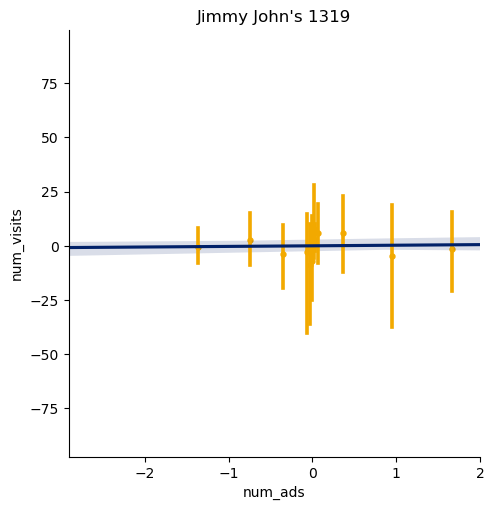

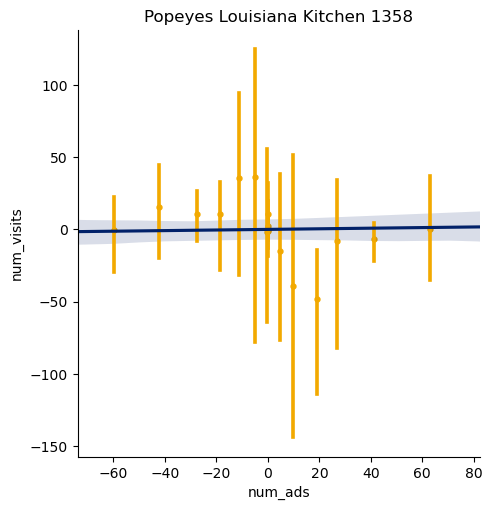

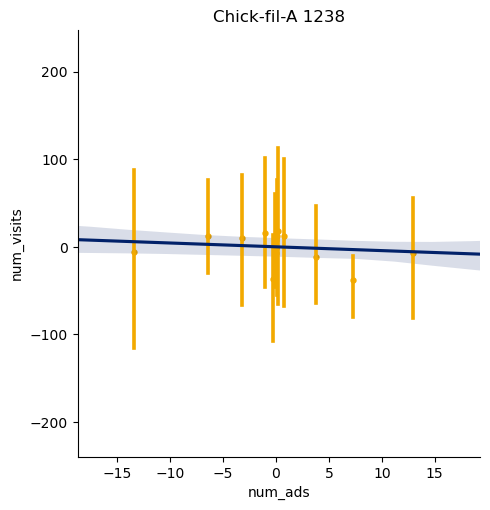

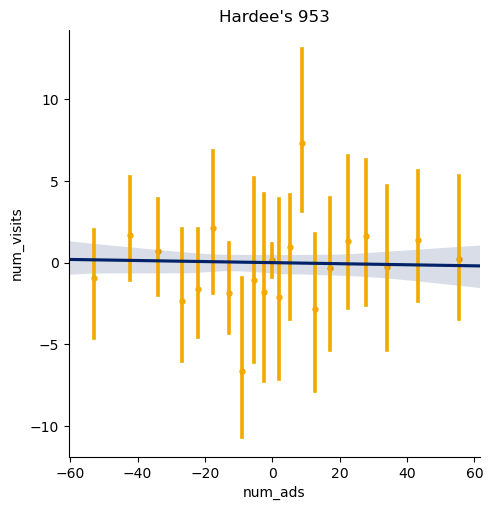

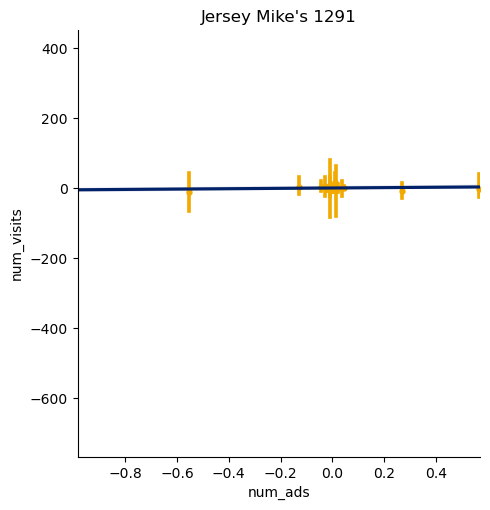

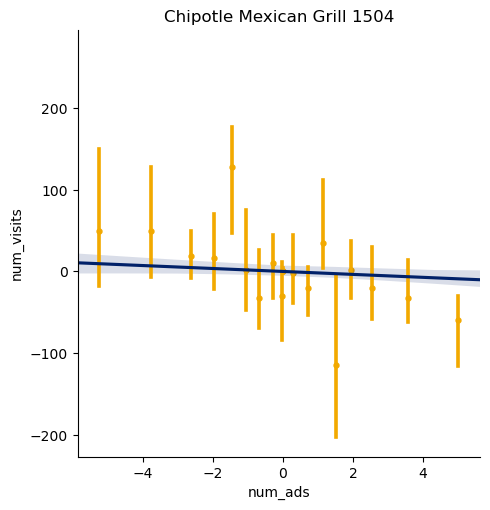

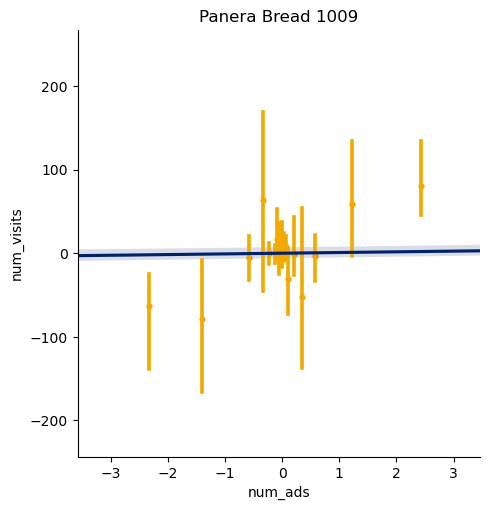

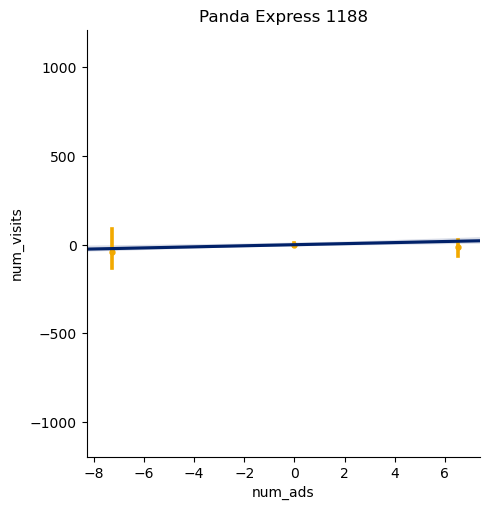

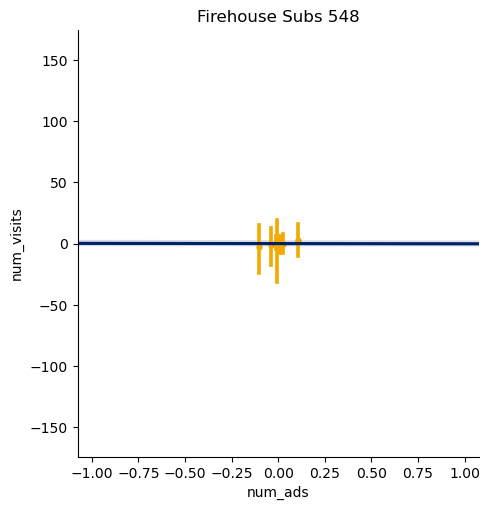

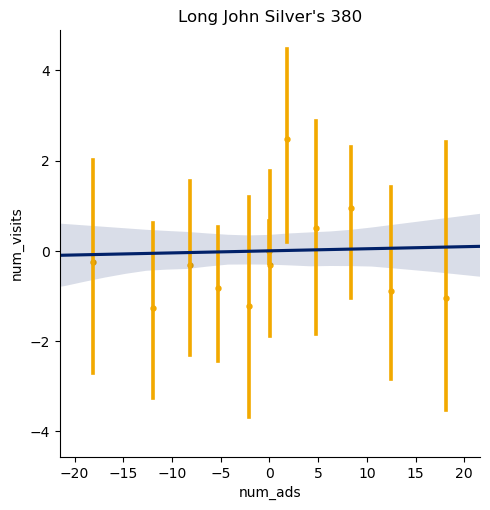

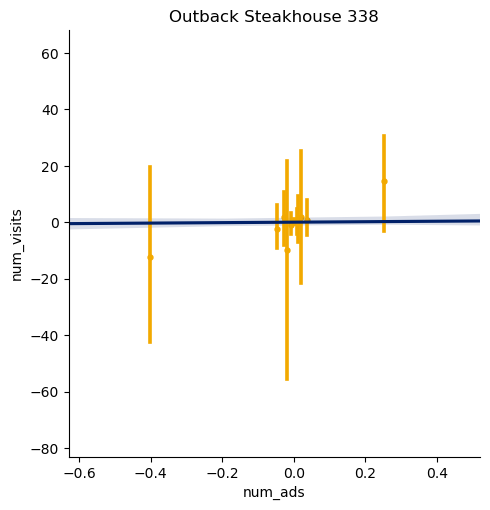

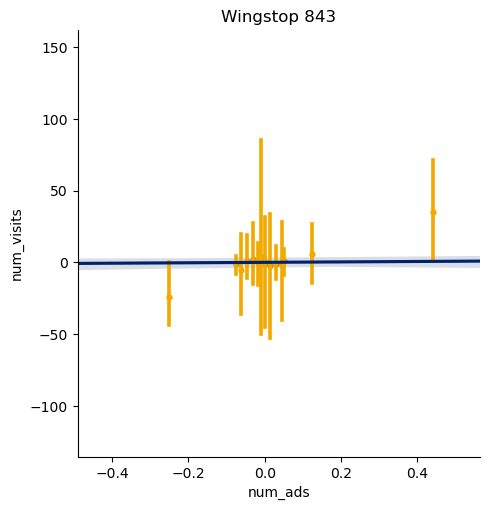

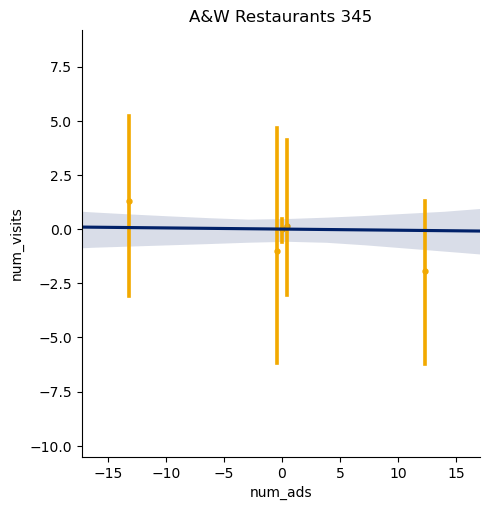

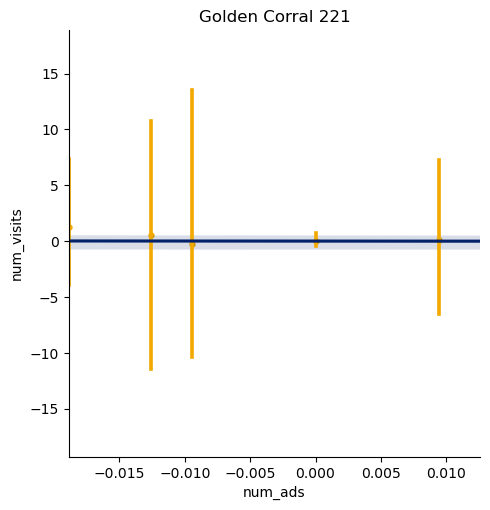

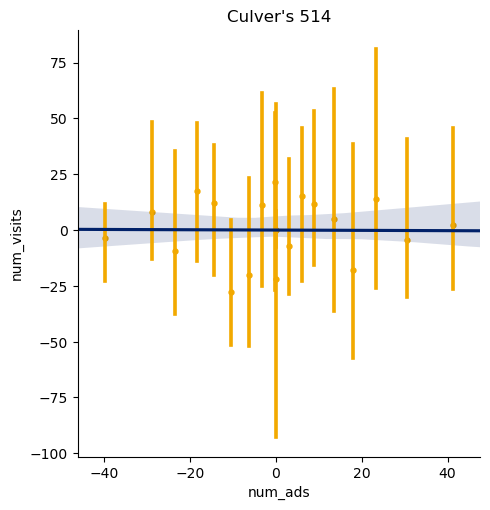

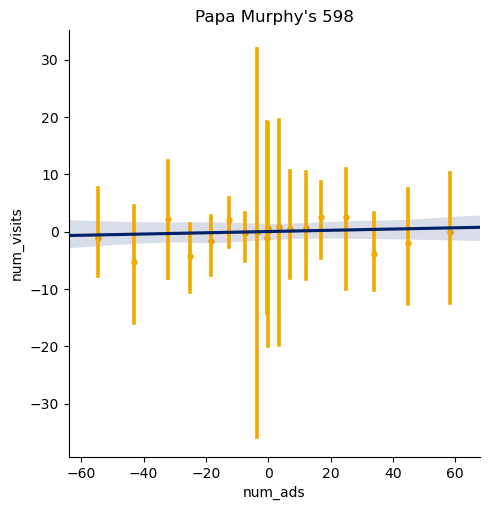

/tmp/ipykernel_243657/1728428425.py:24: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(np.quantile(final_dt["resid_x"], 0.05),np.quantile(final_dt["resid_x"], 0.95))


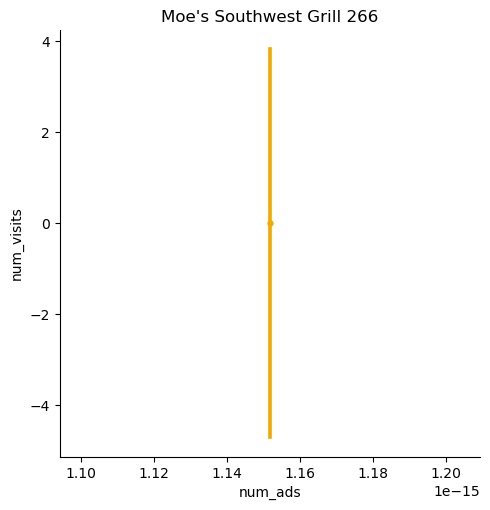

/tmp/ipykernel_243657/1728428425.py:24: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(np.quantile(final_dt["resid_x"], 0.05),np.quantile(final_dt["resid_x"], 0.95))


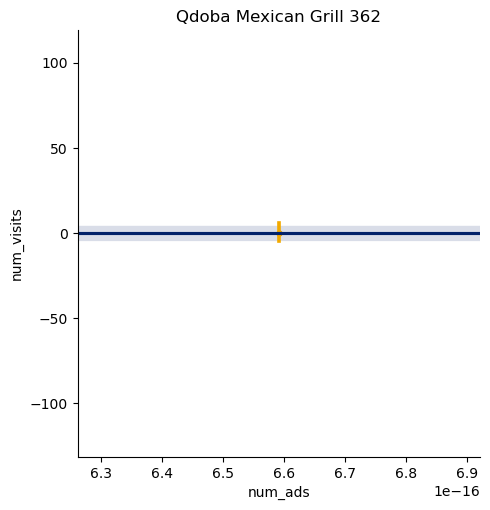

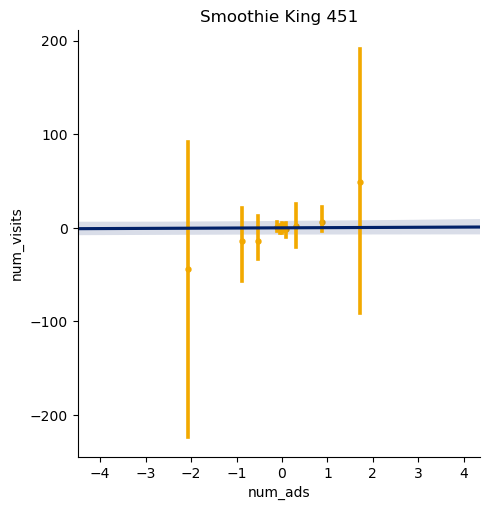

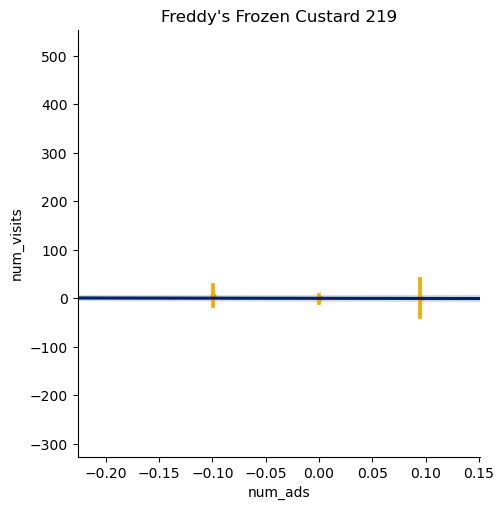

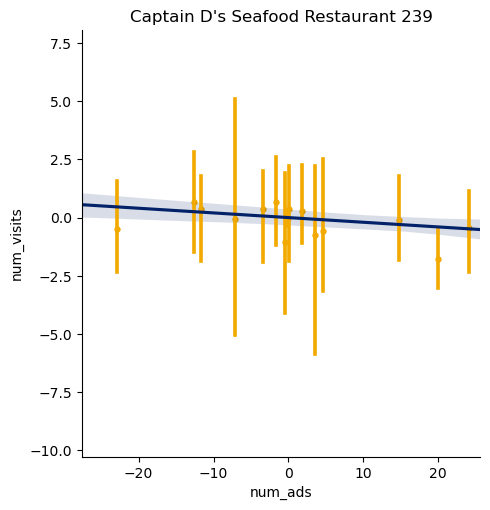

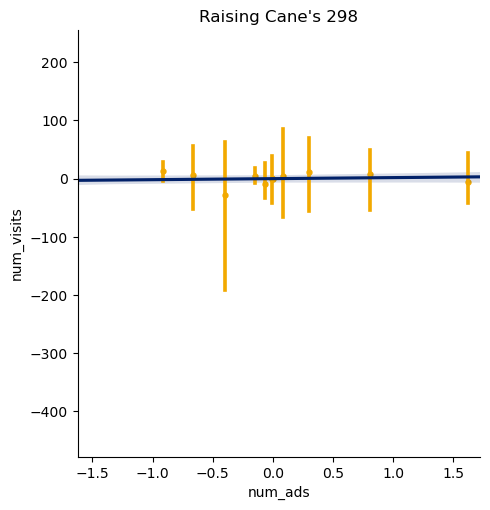

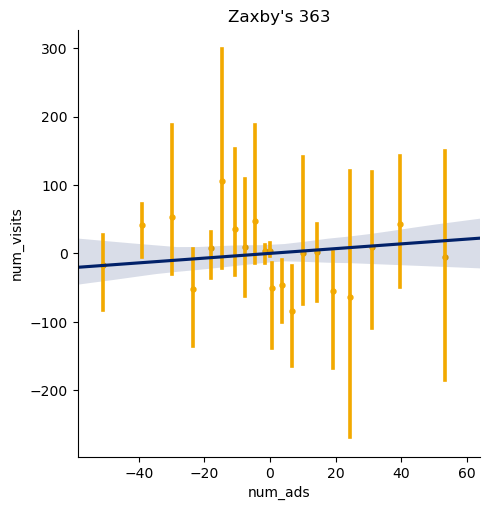

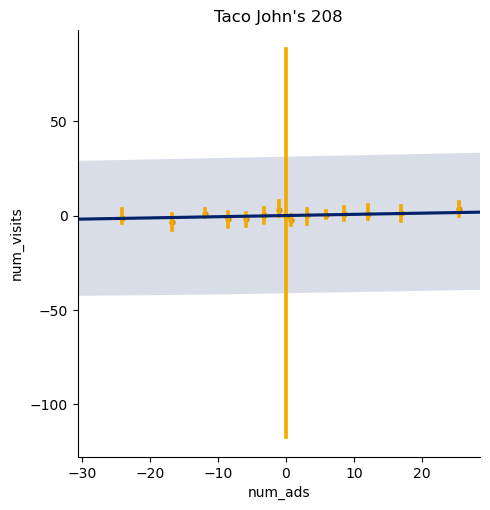

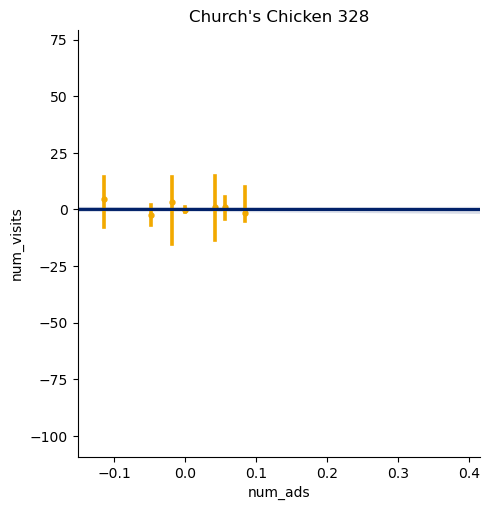

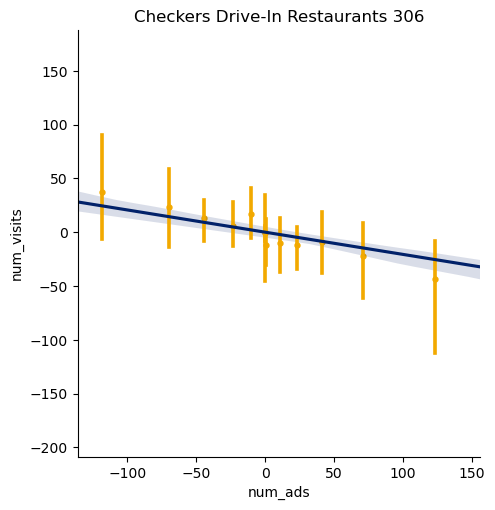

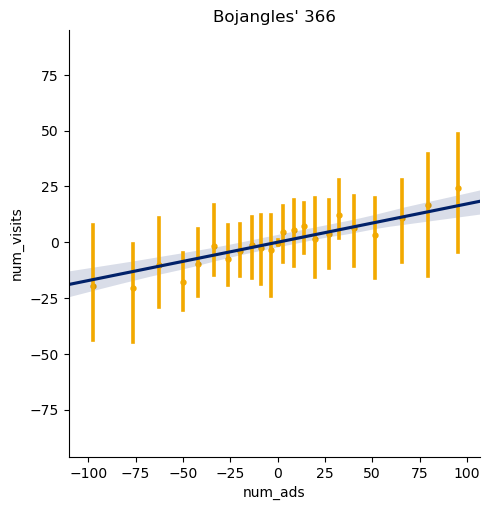

/tmp/ipykernel_243657/1728428425.py:24: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(np.quantile(final_dt["resid_x"], 0.05),np.quantile(final_dt["resid_x"], 0.95))


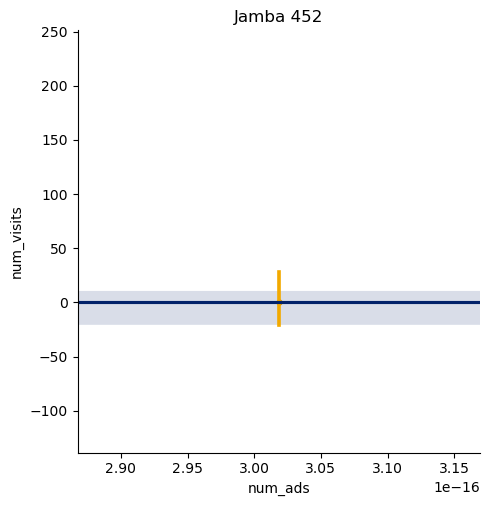

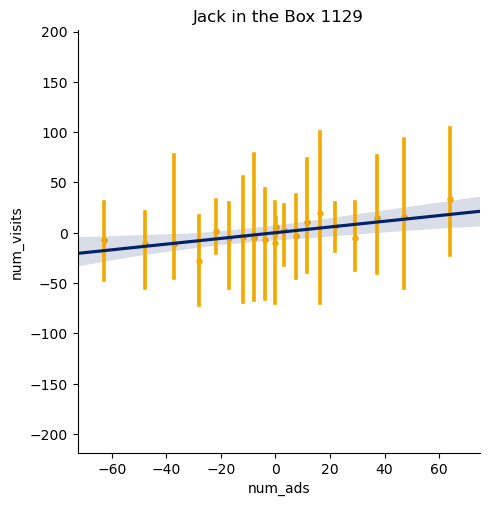

/tmp/ipykernel_243657/1728428425.py:24: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(np.quantile(final_dt["resid_x"], 0.05),np.quantile(final_dt["resid_x"], 0.95))


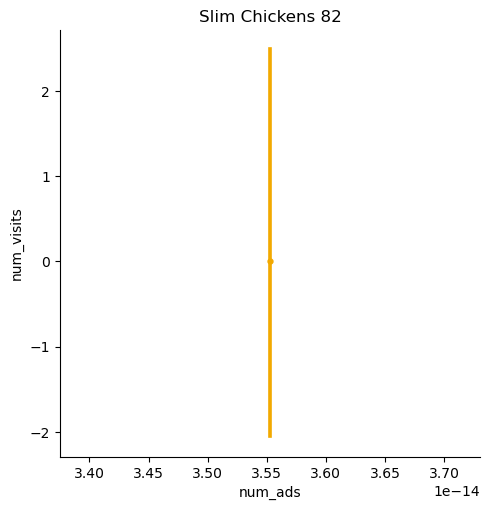

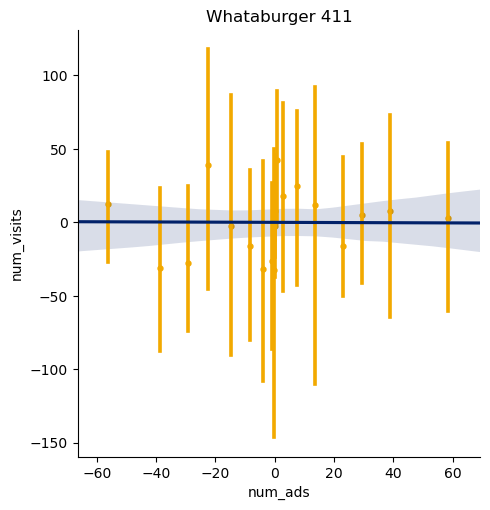

/tmp/ipykernel_243657/1728428425.py:24: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(np.quantile(final_dt["resid_x"], 0.05),np.quantile(final_dt["resid_x"], 0.95))


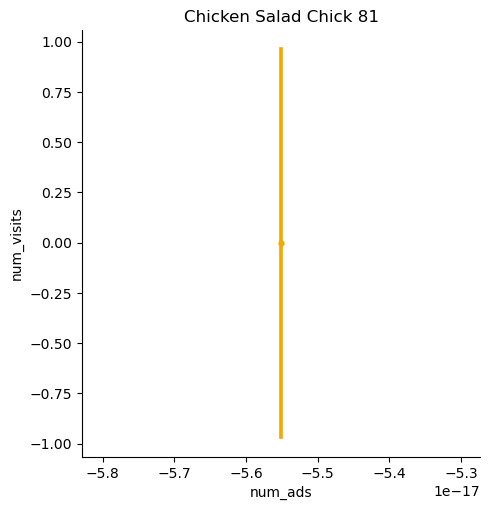

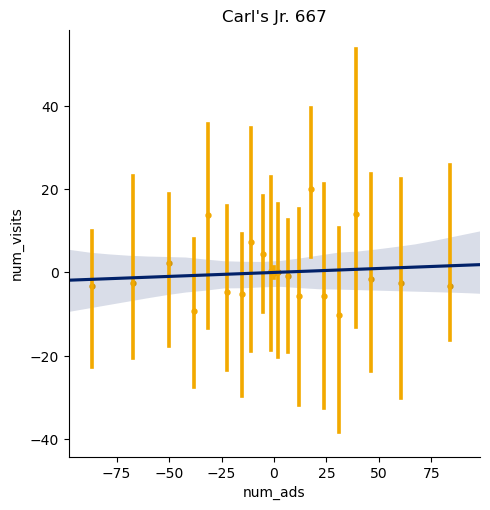

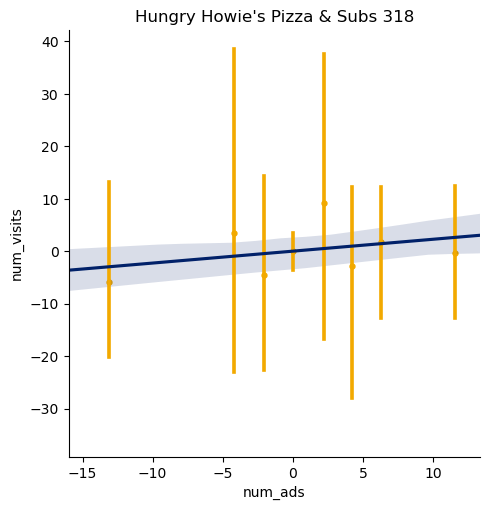

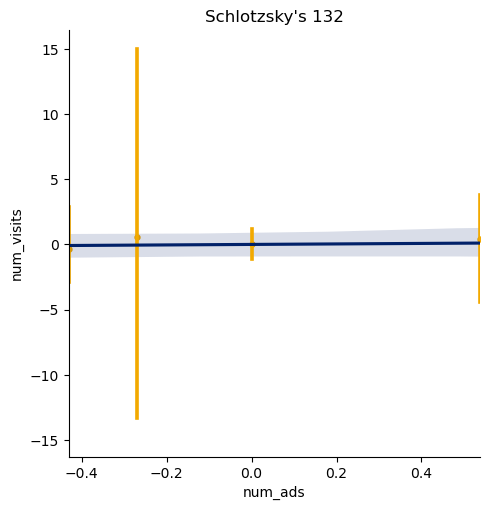

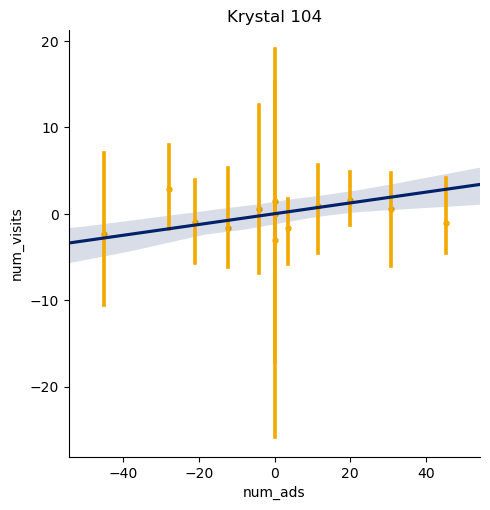

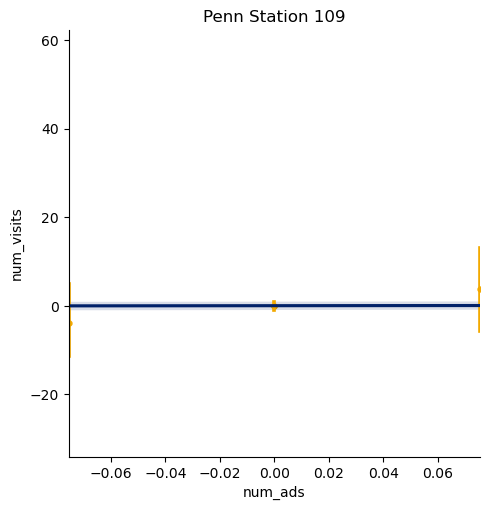

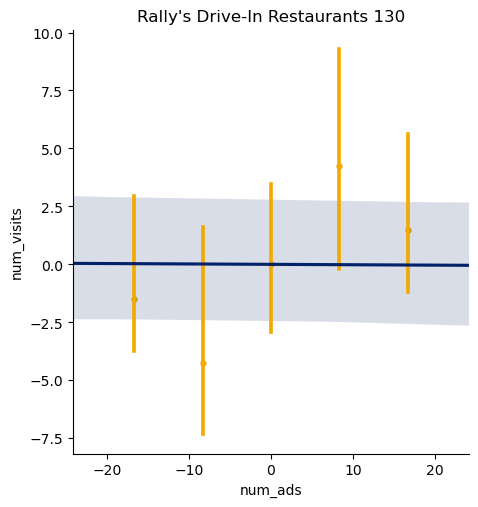

In [16]:
# Plot partial plot
y = "num_visits"
x = "num_ads"
x_control_l = ["interc"]

agg_dt = tran_ads_agg_dt.groupby(["brand_id"], as_index=False)["border_id"].nunique().sort_values(["border_id"], ascending=False)
for brand_id in agg_dt[agg_dt["border_id"]>=40]["brand_id"]:
    final_dt = tran_ads_agg_dt[tran_ads_agg_dt["brand_id"]==brand_id].set_index(["county_id","time"])
    final_dt["interc"] = 1

    mod = lm.PanelOLS(final_dt[y], final_dt[x_control_l], other_effects=final_dt[["brand_border_time_fe","brand_county_fe"]], drop_absorbed=True)
    res = mod.fit()
    final_dt["resid_y"] = res.resids
    
    mod = lm.PanelOLS(final_dt[x], final_dt[x_control_l], other_effects=final_dt[["brand_border_time_fe","brand_county_fe"]], drop_absorbed=True)
    res = mod.fit()
    final_dt["resid_x"] = res.resids
   
    g = sns.lmplot(data=final_dt, x="resid_x", y="resid_y", n_boot=50, logx=False, x_ci = 99, fit_reg=True,
                   x_bins=30,  x_estimator=np.mean, order=1, markers = ["."], truncate=True, scatter_kws={"color":[242/255, 169/255, 0/255]},
                   line_kws={"color":[1/255, 33/255, 105/255]})
    plt.ylabel(y)
    plt.xlabel(x)
    plt.xlim(np.quantile(final_dt["resid_x"], 0.05),np.quantile(final_dt["resid_x"], 0.95))
    plt.title(f"{poi_dt[poi_dt['brand_id']==brand_id]['brand_name'].values[0]} {poi_dt[poi_dt['brand_id']==brand_id].shape[0]}")
    plt.show()